In [1]:
%reload_ext autoreload
%autoreload 2
import torch
from network import *

import numpy as np

In [28]:
model = UNet()
net = model

x = torch.randn(32, 1, 224, 224)
total_params = 0
for name, m in model.named_children():
    y = m(x)
    print(name, ' | ', end='')
    print('output shape: ', y.shape, ' | ', end='')

    x = y

    total_pn = 0
    for pn, p in m.named_parameters():
        if pn.find('weight') != -1:
            param = np.prod(p.shape).item()
            print('Weight Params: ', param, ' | ', end='')
            total_pn += param
        elif pn.find('bias') != -1:
            param = np.prod(p.shape).item()
            print('Bias Params: ', param, ' | ', end='\n')
            total_pn += param
    total_params += total_pn

print('\nTotal Params:\t', total_params)
            
          

maxpool  | output shape:  torch.Size([32, 1, 112, 112])  | conv1  | output shape:  torch.Size([32, 64, 112, 112])  | Weight Params:  576  | Bias Params:  64  | 
Weight Params:  64  | Bias Params:  64  | 
Weight Params:  36864  | Bias Params:  64  | 
Weight Params:  64  | Bias Params:  64  | 
conv2  | output shape:  torch.Size([32, 128, 112, 112])  | Weight Params:  73728  | Bias Params:  128  | 
Weight Params:  128  | Bias Params:  128  | 
Weight Params:  147456  | Bias Params:  128  | 
Weight Params:  128  | Bias Params:  128  | 
conv3  | output shape:  torch.Size([32, 256, 112, 112])  | Weight Params:  294912  | Bias Params:  256  | 
Weight Params:  256  | Bias Params:  256  | 
Weight Params:  589824  | Bias Params:  256  | 
Weight Params:  256  | Bias Params:  256  | 
conv4  | output shape:  torch.Size([32, 512, 112, 112])  | Weight Params:  1179648  | Bias Params:  512  | 
Weight Params:  512  | Bias Params:  512  | 
Weight Params:  2359296  | Bias Params:  512  | 
Weight Params:  

KeyboardInterrupt: 

In [2]:
H, W = 124, 256
grid = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W)))
grid = grid.expand(32, -1, -1, -1)
grid_ = grid.permute(0, 2, 3, 1).transpose(1, 2)
grid_.shape

/opt/homebrew/Caskroom/miniforge/base/envs/biomed/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([32, 256, 124, 2])

In [3]:
import h5py
import matplotlib.pyplot as plt
from PIL import Image

h5f = h5py.File('../data/slices/train/patient001_frame01_0.h5', 'r')
img = h5f['image'][()]
h, w = img.shape
img_ = Image.fromarray(img)
img_ = img_.resize((w,h), Image.NEAREST)
img_ = np.array(img_)
img_.shape, img.shape

((216, 256), (216, 256))

In [4]:
import nibabel as nib

patientId = 'patient021'
imgn = nib.load(f'../data/ACDC_datasets/training/{patientId}/{patientId}_frame13.nii.gz')
img = imgn.get_fdata()
img.shape

(240, 256, 10)

(480, 664)
(480, 664)


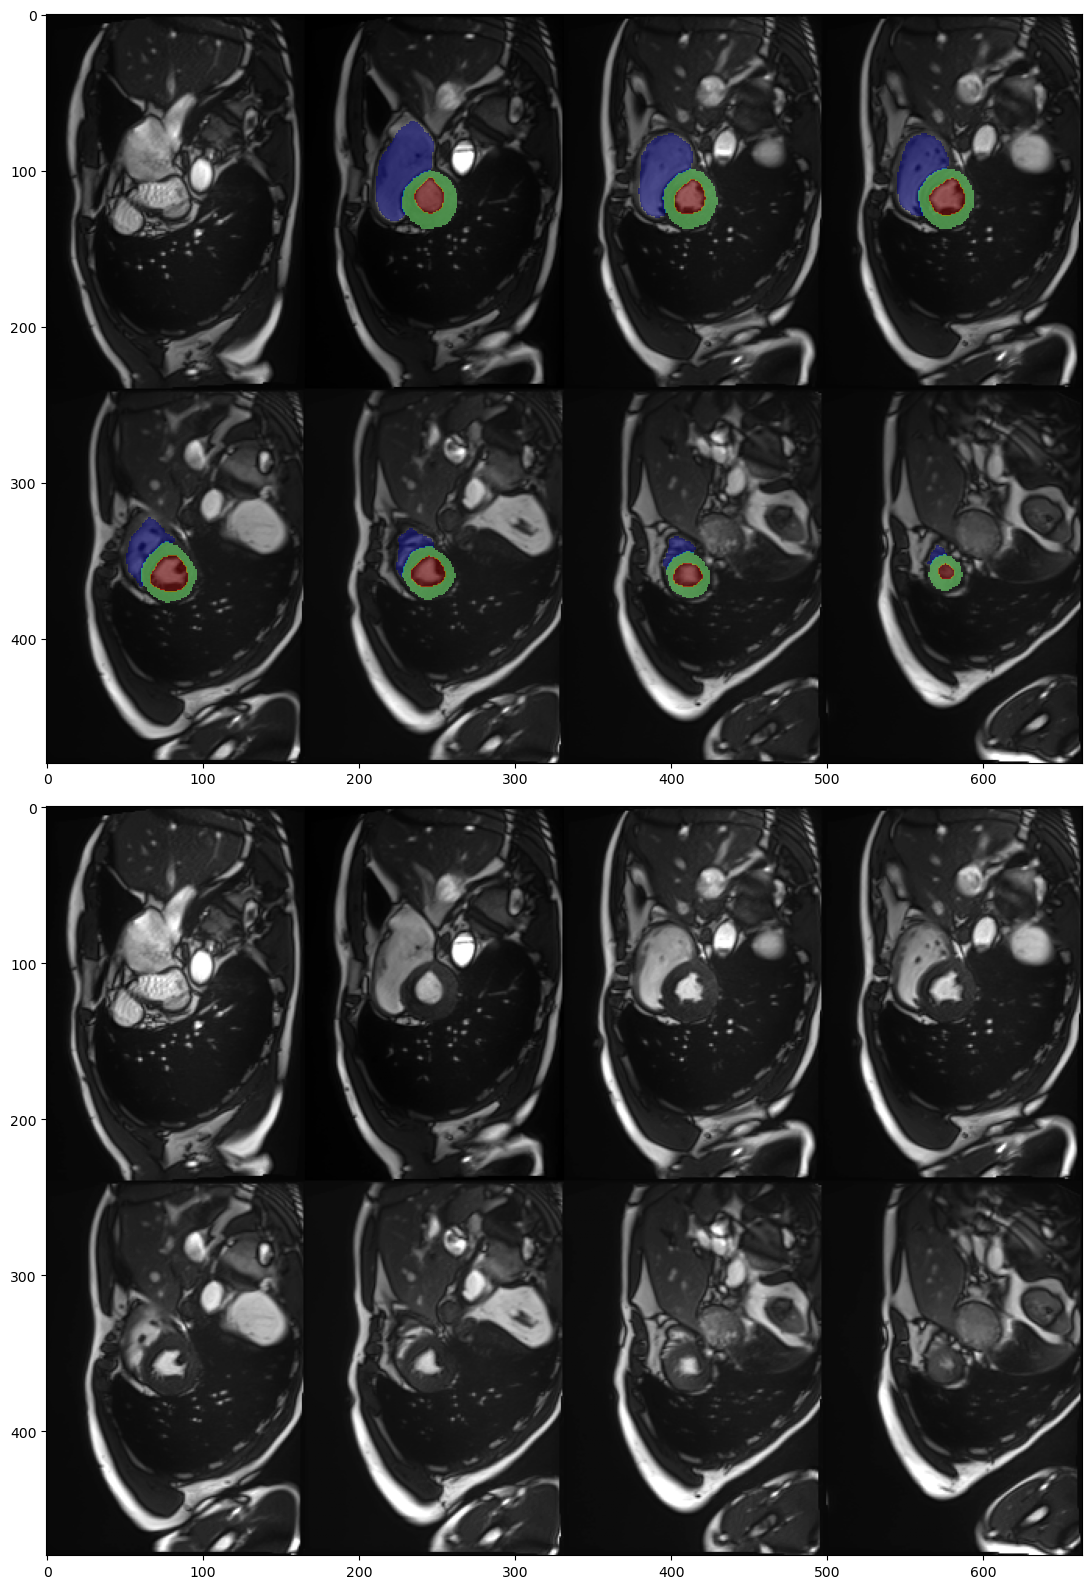

In [19]:
from skimage.util import montage as smon
from glob import glob
import os
import random
from math import ceil

def plot_2d(patient_file):
    nimg = nib.load(patient_file)
    gt_file = patient_file.replace('.nii.gz', '_gt.nii.gz')
    ngt = nib.load(gt_file)

    imgs = nimg.get_fdata().transpose(-1, 0, 1)
    imgs = (imgs - imgs.mean())/imgs.std()
    gts = ngt.get_fdata().transpose(-1, 0, 1)

    p5, p95 = np.percentile(imgs, (0.05, 99.5))
    imgs2 = np.clip(imgs, p5, p95)

    num_cols = ceil(len(imgs)/2)
    
    _, axes = plt.subplots(2, 1, figsize=(3*num_cols, 4*4))
    
    img_mon = smon(imgs, grid_shape=(2, ceil(len(imgs)/2)),
                  fill=0)
    gt_mon = smon(gts, grid_shape=(2, ceil(len(imgs)/2)),
                 fill=0)
    imgs2_mon = smon(imgs2, grid_shape=(2, num_cols),
                     fill=0)
    print(img_mon.shape)
    print(imgs2_mon.shape)

    gt_mask = np.ma.masked_where(gt_mon==0, gt_mon)

    axes[0].imshow(img_mon, cmap='gray')
    axes[0].imshow(gt_mask, alpha=0.5, cmap='jet')

    axes[1].imshow(imgs2_mon, cmap='gray')
    plt.tight_layout()
    plt.show()

root = '../data/ACDC_datasets/testing/'
subdirs = [os.path.join(root, d) for d in next(os.walk(root))[1]]

patients = [glob(d + '/*.nii.gz') for d in subdirs]
patients = [p for sub in patients for p in sub]
patients = [p for p in patients if p.find('_4d')==-1 and p.find('_gt')==-1]
patients = sorted(patients)

pid = patients[random.randint(0, len(patients))]

plot_2d(pid)



(432, 1024)
(432, 1024)


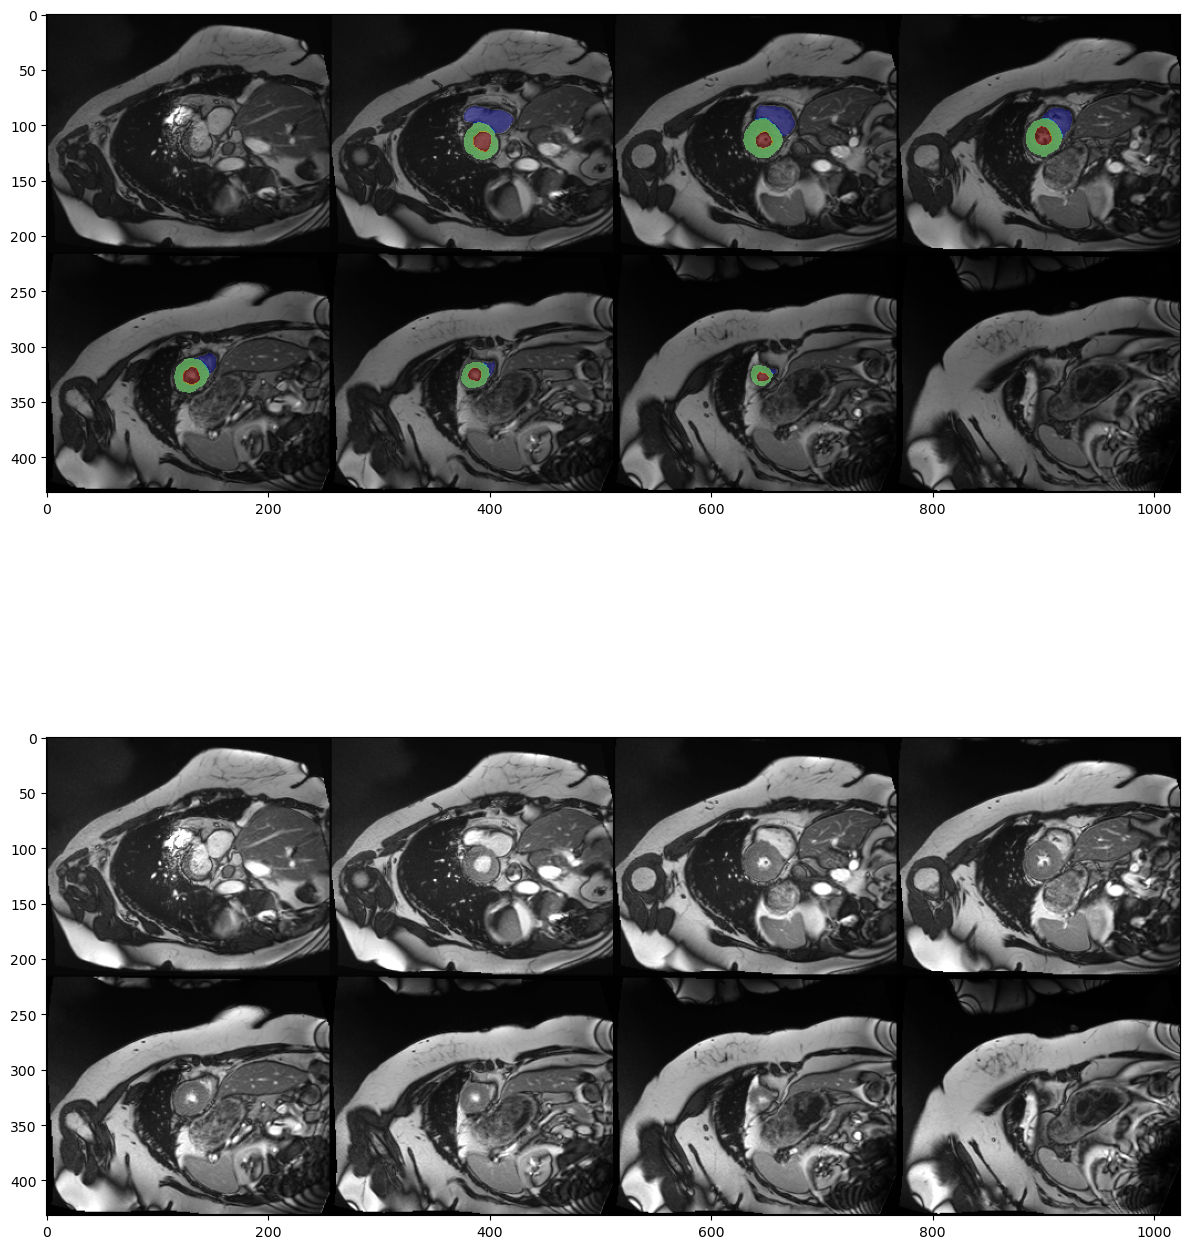

In [30]:
sampleID = '../data/ACDC_datasets/testing/patient102/patient102_frame13.nii.gz'
plot_2d(sampleID)

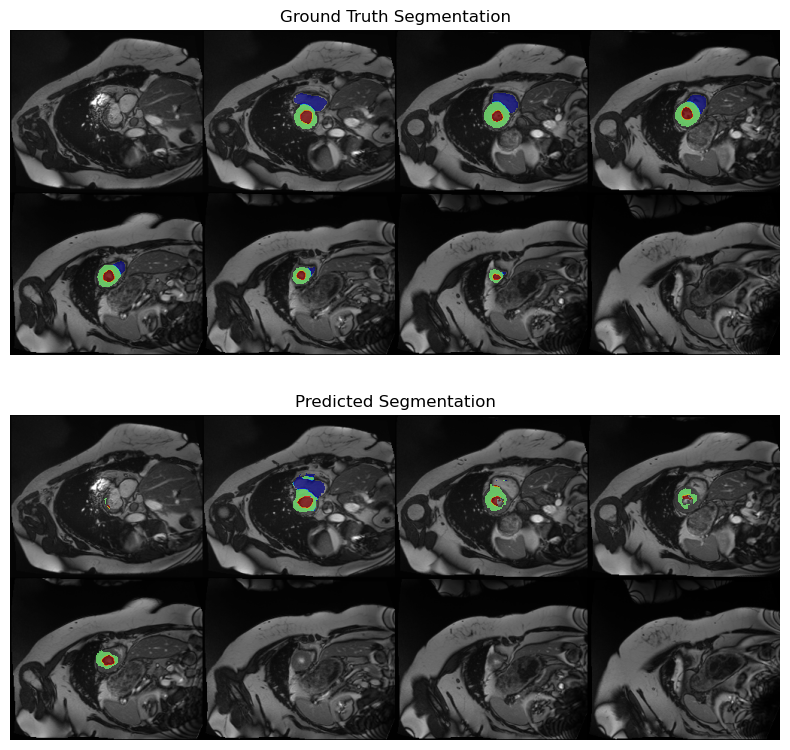

In [32]:
%reload_ext autoreload
%autoreload 2
from inference import *

model = UNet()
checkpoint = '../tmp/UNetDeeper_logits_dicece_1011/checkpoint.pth.tar'
inference = Inference(model, checkpoint, size=224)
inference.plot(sampleID)

In [12]:
import torchvision.transforms.functional as F

img_ = img.transpose(-1,0,1)
img_t = F.to_tensor(img)
img_.shape,  img_t.shape

((9, 208, 256), torch.Size([9, 208, 256]))

In [15]:
img_s = F.resize(img_t, (224,224),antialias=False)
img_s.shape

torch.Size([9, 224, 224])

In [18]:
mask_f = pid.replace('.nii.gz', '_gt.nii.gz')
label = nib.load(mask_f).get_fdata()


False